# Sentiment and Text Analysis of Game of Thrones wiki - Fandom

## Motivation

To conduct sentiment and text analysis for this project, we chose to specifically look at a specific number of characters from a Wikipedia Fandom page to see what we can learn about the characters storyline when fans are the authors. We will also conduct a sentiment analysis with the use of a subjectivity lexicon to analyse if the language used on the character's pages is positive/negative/neutral in sentiment, and if there is weak or strong subjectivity. 

The reason we chose to use the Fandom page instead of the books, was that alle characters have their own page; so all of the needed information and judgements about the characters are gathered in one place. We hope that this will provide a more accurate analysis on the characters. 

Many people have probably seen Game of Thrones, so it would be interesting for us and the user to see if we can learn about how the characters act and behave in the storyline thorugh text analysis. If someone is familiar with Game of Thrones they might be able to relate more to the analysis, compared to someone that is not. Thus, this analysis might give those who are unfamiliar with Game of Thrones insight to certain characters without watching the series.

#### Chosen characters for text and sentiment analysis:
 - Cersei Lannister
 - Tyrion Lannister
 - Jon Snow
 - Daenerys Tagaryen
 - Arya Stark

Since there are 389 characters total (from a downloaded character dictionary), there would be too many to analyse and a lot of characters are insignificant. Thus, we have chosen to conduct sentiment and text analysis on the 5 characters mentioned above. These were chosen due to their longevity in the series and thus we will be able to conduct a more in-depth analysis. In this batch there are characters whose stories are sometimes intertwine, but a huge aspect is their indiviudal journey and character development.    

Additionally we will compare each of the character's documents from a subjectivity lecixon, which can be downloaded here: [Subjectivity Lexicon](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/) (the lexicon will also be available as a CSV, however, some of the attributes have been removed for this analysis)

From this we can see how subjective the words used for each character is, but also the polarity (negative/positive/neutral) of each character. Therefore our objective in this part is to be able to see if we can conclude which characters are positively/negatively/neutrally in sentiment and weak/strong in subjectivity. We hope that the users might in a prediction about the sentiment of a character.

## Data

In this section we will explore the data we will be analysing. There will also be a section with functions that are used for web scarping, pre-processing, etc.

For the text analysis we will use text from the [Fandom](https://gameofthrones.fandom.com) page and specifically the five mentioned character's pages. Each character has several sections, such as:
1. Biography
2. Personality
3. Relationships
4. Appearances
5. Quotes
6. Family Tree
7. Behind the Scenes
8. In the Books
9. See Also
10. References

For the rest of this notebook, we will only create documents form each character using the **Biography** and **Personality** section, as these sections describes the characters role in the series, their actions, and who they are. 

In [1]:
# Import needed libraries
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from nltk import word_tokenize
from urllib.request import urlopen
from nltk.corpus import stopwords
import json
import nltk 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Stopwords are removed from each document, so as not to influence the analysis as stop words are unimportant to 
# the characters storyline (aka. these are not the words that has any important value)
stop_words = stopwords.words('english')

# the word 'not' is kept, as this is can be an important contextual word for sentiment
stop_words.remove('not')
# some words that frequently have occured, but are not important we have added to the set
stop_words.extend(['tells', 'asks', 'however', 'though', 'also', 'later', 'nt', 'say', 'hound', 'says'])
stop_words = list(stop_words)

In [3]:
# Character names for sentiment and text analysis are removed, since we wish to understand the individual characters
# we are not concerned with the different relations between characters. So we remove the characters that are defined
# in the .json file
CharacterNames = []
with open('characters.json') as json_file:
    data = json.load(json_file)
    for p in data['characters']:
        CharacterNames.append(p['characterName'])
CharacterNames = ' '.join(CharacterNames)
CharacterNames = CharacterNames.split()
CharacterNames = [item.lower() for item in CharacterNames]

In [4]:
# Family members such as father, mother, etc., are removed, not because these family relations are unimportant
# but we want to gain more perspective about them as individuals
FamilyMembers = ['father', 'mother', 'nephew', 'cousin', 'wife', 'brother', 'sister', 'niece', 'son', 'daughter', 
                'surname', 'grandfather', 'grandmother', 'men', 'women', 'brothers', 'daughters', 'children', 'child', 'edd']

In [5]:
characters = ['Jon Snow', 'Cersei Lannister', 'Tyrion Lannister', 'Daenerys Targaryen', 'Arya Stark']

### Functions
Here are different functions defined such as: to obtain the needed data, cleaning data, and analysing data. In our Network explainer Notebook, these functions are explained more in depth.

In [6]:
# This function takes a text (for each character) and the different lists defined above and returns a document
# for that character

def clean_data(text, FamilyMembers, CharacterNames, stop_words):
    digits = '[0-9]'
    symbols = '[!#$%&()*+-./:;<=>?@[\]^_`{|}~\n]'
    
    doc = text
    # remove digits
    doc = [re.sub(digits, '', i) for i in doc]
    # remove symbols
    doc = [re.sub(symbols, '', i) for i in doc]
    # remove single characters
    doc = [re.sub('\\b[^(aiouvAIOUV)]{1} \\b', ' ', i) for i in doc]
    # remove links 
    doc = [re.sub(r'http\S+', '', i) for i in doc]
    # remove punctuation
    doc = [re.sub(r'[^\w\s]', '', i) for i in doc]
    # remove html syntax (\t and \n)
    doc = [re.sub(r'[\t\n\r]', '', i) for i in doc]
    # remove white spaces
    doc = [re.sub('(?<=\n)\s+\n', '', i) for i in doc]
    # stopwords, family member, character names
    doc = [w for w in doc if not w in stop_words]
    doc = [w for w in doc if not w in FamilyMembers]
    doc = [w for w in doc if not w in CharacterNames]

    return doc

In [7]:
# Obtaining character description for the 5 chosen characters using web scarping
# from the wikipedia fandom page using beautiful soup

def CharDescription(root, endpath):
    path = root+endpath
    req = requests.get(path)
    html_page = req.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)

    output = ''
    blacklist = [
        '[document]',
        'noscript',
        'header',
        'html',
        'meta',
        'head', 
        'input',
        'script',
    # there may be more elements you don't want, such as "style", etc.
    ]
    
    for words in text:
        if words.parent.name not in blacklist:
            output += '{} '.format(words) 

    return soup, text, output
            

In [8]:
# For each character page, there are only certain sections that we want to analyse

def GetSectionName(soup):

    AllH = soup.find_all(['h2', 'h3'])
    for header in AllH:
        if header.span is not None: 
            header.span.unwrap()
    
    # these are the headers we want for our text: biography and personality
    AllHeaders = [header.text for header in AllH]
    if 'Biography' in AllHeaders:
        Pre = AllHeaders.index('Biography')
    elif 'Personality' in AllHeaders: 
        Post = AllHeaders.index('Personality')
    else: 
        print("something went wrong")
        return
    Post = AllHeaders.index('Appearances')

    HeadlineName = AllHeaders[Pre+1:Post]
    return HeadlineName

In [9]:
# From the character description and section name we can obtain the text we want to analyse

def GetText(HeadlineNames, soup):
    HeadlineNames += ['Appearances']

    # Unwrap text
    Texts = soup.find_all(['p','h2', 'h3'])
    for section in Texts: 
        if section is not None:
            if section.a is not None: 
                section.a.unwrap()
            elif section.span is not None: 
                section.span.unwrap()

    #Store text in list
    Texts = [t.text for t in Texts]

    # Find section indices in Texts
    CaptionIndices = []
    for caption in HeadlineNames:         
        CaptionIndices.append(Texts.index(caption))

    # Store texts according to section
    SectionText = []
    for i in range(len(CaptionIndices)-1):
        SectionText.append(Texts[CaptionIndices[i]+1:CaptionIndices[i+1]])


    return SectionText

In [10]:
# We define a function of lexical diversity, to see how unique a character's document is
def lexical_diversity(text):
    return len(set(text)) / len(text)

In [11]:
# Wordcloud drawings

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if word != 'edd'
                            and word != 'nt'
                            and word != 'one' 
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(7, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [12]:
# Endpaths of the chosen characters (used to obtain character descriptions)

char_wiki = ['/wiki/Jon_Snow',
             '/wiki/Cersei_Lannister',
             '/wiki/Tyrion_Lannister',
             '/wiki/Daenerys_Targaryen',
             '/wiki/Arya_Stark']

In [13]:
root = 'https://gameofthrones.fandom.com'

## Tools, Theory, and the Analysis

In this section, we seperate the five characters and firstly analyse their character pages indivudally. For this we will look at their lexical diversity to see how diverse the language is, collocations to see which two words often occur together - to attain some information about their storyline, and lastly wordclouds to see which words appear the most in their document. All in all, the individual analysis should provide the user information about each character from the character descriptions from the Fandom page. 

The next section will be a comparative analysis where we tackle subjectivity and sentiment analysis, and compare the results generated from each characters; to see if there is a difference between sentiment and subjectivity, as well as see if we can assert if there is bias in the fandom. 

### Jon Snow
In this section we are analysing and obtaining the text to be analysed for Jon Snow. 

Brief summary of [Jon Snow](https://gameofthrones.fandom.com/wiki/Jon_Snow):
<br>
Jon is perceived in the beginning as an outsider, but over the course of the story he finds his place in the Night’s Watch. Jon is very independent and knows how to fend for himself. Jon has earned responsibilities rather than received them as a result of his noble heritage. His skills with a sword, his wisdom, and devotion to others earns him a place as the Commander's successor. He gets betrayed by some of the men from the Night's Watch due to his affiliation with the Wildlings (aka. Free Folk). He is then resurrected, the rest of the storyline he proceeds to help out his sisters, helping Daenerys to take the Iron Throne and lead the Seven Kingdoms. 

In [14]:
# Get the soup, text, and output for Jon Snow to clean the data
soup, text, output = CharDescription(root, char_wiki[0])
head = GetSectionName(soup)
desc = GetText(head, soup)
list_desc = [j for i in desc for j in i]

In [15]:
# Tokenize the words and sentences
JS = ' '.join(list_desc)
JS = JS.strip()
JS = word_tokenize(JS.lower())

In [16]:
jon = clean_data(JS, CharacterNames, FamilyMembers, stop_words)

In [17]:
# Removing empty strings
jon = [x for x in jon if len(x.strip()) > 0]

In [18]:
# From the NLTK book, we learned that we can analyse tokens as text, by doing the following (this will be used to find lexical diversity):
text_js = nltk.Text(jon)

In [19]:
# Lexical diversity
lexical_diversity(text_js)

0.3829145728643216

From the lexical diversity, we can see that the number of distinct words is 38.2% of the total number of words. The document is overall moderately diverse.

In [22]:
text_js.collocations()

seven kingdoms; iron throne; beyond wall; bend knee; free folk; mole
town; bids farewell; army dead; heart tree; punished crimes; runt
litter; atop wall; valyrian steel; new recruits; shadow tower; tower
joy; years ago; bent knee; fist first; tries persuade


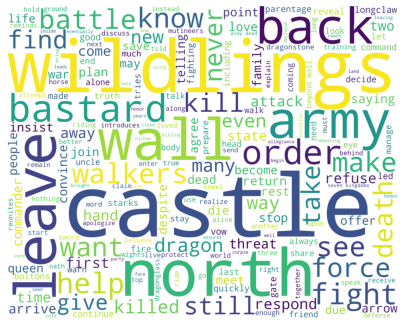

In [31]:
# Generate wordcloud
wordcloud_draw(jon, 'white')

#### What can we learn about Jon Snow from this?
From the document generated for Jon Snow what does the analysis and wordcloud say about him - what can we say and/or what can we learn about Jon Snow?

From the collocations we see that the words who frequently occurs together is that of:
> 1. Beyond Wall:
>> * This is the northeren most part of Westeros where the free folk lives.
> 2. Free Folk:
>> * aka. the Wildlings (that is what people south of the wall calls them). The Free Folk comprises of hundreds of big and small tribal communities.
> 3. Bend Knee:
>> * Bending ones knee implies that the person submit to another's person rule, showing complete loyalty towards that person.
> 4. New Recruits:
>> * New recruits for the Night's Watch comes from many places; young boys, criminals, etc.

From the collocations we can see how Jon Snow is a big part of the Night's Watch during his storyline, how he has been some of the few who has been beyond the wall (and he later becomes the successor of the commander). He is helping with the new recruits and training them. He gets captured by the Free Folk, where he eventually helps them to the other side of the wall (Westeros) to get them away from the army of the dead. Jon often has found him in a position where he is asked to pledge his loyality by bending his knee. Daenerys asks him multiple times and in the end he does indded bend his knee.  

From the worldcloud, some of the interesting words:
> * Castle
> * Wildlings
> * North
> * Leave
> * Wall
> * Army
> * Bastard
> * Kill

What does these words say about Jon Snow? He is involved with a lot pertaining to war and battles: he is a warrior. He is from the North and lives at Castle Black for a long period. He becomes the link between wildlings and Westeros. He is known from the earlier parts of the series as **the bastard**.  

We can definitly see a link between Jon's storyline and the generated collocations and wordcloud.  

### Cersei Lannister
In this section we will look at Cersei Lannister. 

Brief summary of [Cersei Lannister](https://gameofthrones.fandom.com/wiki/Cersei_Lannister):
<br>
She became the Queen of the Seven Kingdoms after a rebellion. She is hungry and greedy for power, and she believes herself to be politically perceptive. She hates being excluded from power and resents the customs and conventions put on her because she is a woman. She thinks highly of herself and feels slighted when people do not obey her commands. Cersei is also very impatient, and considers caution to be cowardice and disagreement for defiance. Her quick temper and her easily wounded pride frequently lead her to make rash decisions, and she rarely considers what unintended consequences her actions might have. After failure to maintain the power over the seven kingdoms and mainting influence in the King's Landing, she steadily declines during the series. 

In [20]:
soup, text, output = CharDescription(root, char_wiki[1])
head = GetSectionName(soup)
desc = GetText(head, soup)
list_desc = [j for i in desc for j in i]

In [21]:
CL = ' '.join(list_desc)
CL = CL.strip()
CL = word_tokenize(CL.lower())

In [22]:
cersei = clean_data(CL, CharacterNames, FamilyMembers, stop_words)

In [23]:
cersei = [x for x in cersei if len(x.strip()) > 0]

In [24]:
text_cl = nltk.Text(cersei)

In [46]:
# Lexical diversity
lexical_diversity(text_cl)

0.4401643554185927

From the lexical diversity, we can see that the number of distinct words is 44% of the total number of words. Her document is quite diverse and almost half are unique words.  

In [29]:
text_cl.collocations()

faith militant; sept baelor; seven kingdoms; small council; casterly
rock; iron throne; incestuous relationship; golden company; trial
combat; walk atonement; game thrones; iron bank; queen regent; army
dead; starks targaryens; maegor holdfast; strangled sleep; visibly
horrified; forced walk; crushed debris


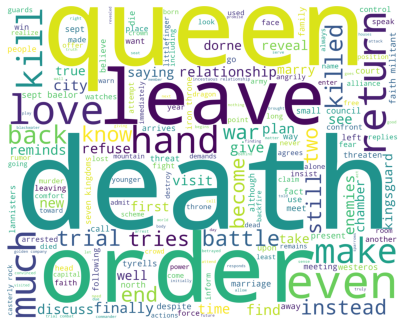

In [30]:
# Generate wordcloud
wordcloud_draw(cersei, 'white')

#### What can we learn about Cersei Lannister? 

From the collocations we see that the words who frequently occurs together is that of:
> 1. Faith Millitant:
>> * This is the military order of one of the dominant religions; in the series they are reffered to as "sparrows", when they establish themselves in King's Landing, they enforce their strict religious values on the nobility and smallfolk alike
> 2. Small Council:
>> * Is a council that dicsuss the current rules, if there should be new ones, guides the King.
> 3. Incestuous Relationship:
>> * Relationship between relatives
> 4. Walk Atonement:
>> * A walk thorugh King's Landing naked as punishment

From the collocations we get a pretty accurate depiction on some of the main events in Cersei's storyline. She is a part of the small council where she loves to assert her power. We know she has an intimate relationship with her brother Jaimie, who is also the father of all of her children. When the Sparrows establish themselves in King's Landing, and the high sparrow aqcuires influence on the King (Cersei's youngest son). She gets taken and admits her sin: her involvement in a incestuous relationship. To repent her sins, she does the walk of atonement.

From the worldcloud, some of the interesting words:
> * Queen
> * Death
> * Love
> * Order
> * Leave

Cersei is the Queen for the most part of the storyline in the Seven Kingdoms, ruling and is involved with many deaths. She loves order and power.  

For Cersei we can definitely see some sort of a storyline, at least being able to highlight some of the main events she involved with. We also get some insight into her relationships.  

### Tyrion Lannister
In this section we will look at Tyrion Lannister

Brief summary of [Tyrion Lannister](https://gameofthrones.fandom.com/wiki/Tyrion_Lannister):
<br>
Tyrion is a dwarf; because of this he is sometimes called the Imp and the Halfman. Tyrion is intelligent, well educated, and a ferocious reader. He is sharp of wit and tongue. Even though he is no warrior, he shows great bravery in battle. He generally receives little respect and is often mocked. His deformity is the cause of many problems and persecution, although mitigated to some extent by his high social standing and his family's wealth and power. He craves for love and respect from his family, but does not have a good relationship with all his family members. After he murders his father, he flees away from Westeros and becomes the right hand of Daenerys. 

In [25]:
soup, text, output = CharDescription(root, char_wiki[2])
head = GetSectionName(soup)
desc = GetText(head, soup)
list_desc = [j for i in desc for j in i]

In [26]:
TL = ' '.join(list_desc)
TL = TL.strip()
TL = word_tokenize(TL.lower())

In [27]:
tyrion = clean_data(TL, CharacterNames, FamilyMembers, stop_words)

In [28]:
tyrion = [x for x in tyrion if len(x.strip()) > 0]

In [29]:
text_tl = nltk.Text(tyrion)

In [32]:
# Lexical diversity
lexical_diversity(text_tl)

0.40262304329431675

From the lexical diversity, we can see that the number of distinct words is 40.2% of the total number of words. This is also quite a diverse document. 

In [54]:
text_tl.collocations()

casterly rock; small council; sons harpy; seven kingdoms; trial
combat; hill tribes; iron throne; battle blackwater; mud gate; slaver
bay; fighting pit; tower hand; iron bank; last time; bids farewell;
throne room; drink death; sake unborn; sense humor; iron islands


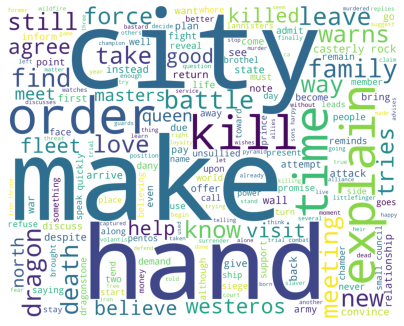

In [39]:
# Generate wordcloud
wordcloud_draw(tyrion, 'white')

#### What can we learn about Tyrion Lannister? 

From the collocations we see that the words who frequently occurs together is that of:
> 1. Slaver Bay:
>> * Is the area on the southern coast of Essos. As the name implies, the cities of the Slaver's Bay were the hub of the international slave trade.
> 2. Small Council:
>> * Is a council that dicsuss the current rules, if there should be new ones, guides the King.
> 3. Trial Combat:
>> * A trial by combat is a means by which a party can prove their innocence when accused of a crime in the Seven Kingdoms by combat.
> 4. Sense Humour:
>> * Sense of humour, entertaining, funny, etc. 

From the collocation, we can see how he has a relation to the small council. We know that Tyrion Lannister did a trial by combat, due to people believing he posioned Joffrey. He then flees after murdering his father and meets Daenerys in one of the Free Cities. Tyrion is mostly known for being witty, always having a funny remark, and is very talkative.  

From the worldcloud, some of the interesting words:
> * Hand
> * Explain

The most interesting words are "hand" and "explain". He becomes Daenerys' right hand, he is also some sort of spokesman where he explains many things to Daenerys and the others about how to get to Westeros with the most resources. Also he communicates well in Slaver's Bay with the high-ups on the behalf of Daenerys 

Here it is difficult to conclude anything specific about the concrete storyline, however, we are able to read some of the main events: small council, trial by combat, battle of blackwater, becomes Daenerys' right-hand.  

### Daenerys Targaryen 
Now we will analyse Daenerys. 

Brief summary of [Daenerys Targaryen](https://gameofthrones.fandom.com/wiki/Daenerys_Targaryen):
<br>
Princess Daenerys Targaryen, also known as Daenerys Stormborn, is one of the last confirmed members of House Targaryen. As she was raised in exile, and gets married off to the khal. Among the Dothraki, she feels safe, loved and hopeful for the first time. She is the mother of Dragon and thus, she owns three of them. She walks around the free cities in Essos to free the slaves and recruit armies before returning to Westeros and claim the Iron Throne. Her father is known for his mental breakdown, an insane king, and in the last few episodes this becomes her faith as well when she decides to burn an entire city down.  

In [30]:
soup, text, output = CharDescription(root, char_wiki[3])
head = GetSectionName(soup)
desc = GetText(head, soup)
list_desc = [j for i in desc for j in i]

In [31]:
DT = ' '.join(list_desc)
DT = DT.strip()
DT = word_tokenize(DT.lower())

In [32]:
dae = clean_data(DT, CharacterNames, FamilyMembers, stop_words)

In [33]:
dae = [x for x in dae if len(x.strip()) > 0]

In [34]:
text_dt = nltk.Text(dae)

In [61]:
# Lexical diversity
lexical_diversity(text_dt)

0.1868035703867919

From the lexical diversity, we can see that the number of distinct words is 18.6% of the total number of words. Daenerys has poor diversity in her document. 

In [62]:
text_dt.collocations()

iron throne; seven kingdoms; second sons; dosh khaleen; slaver bay;
army dead; vaes dothrak; bend knee; casterly rock; throne room; dragon
eggs; fighting pits; changed mind; game thrones; burned alive; break
wheel; wise masters; size small; three dragons; powerful friends


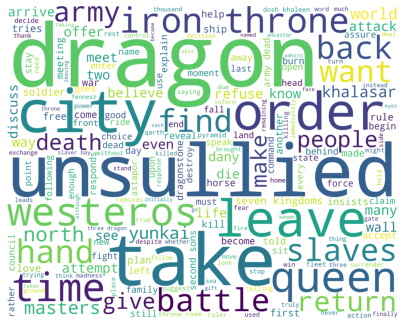

In [48]:
# Generate wordcloud
wordcloud_draw(dae, 'white')

#### What can we learn about Daenerys Targaryen? 

From the collocations we see that the words who frequently occurs together is that of:
> 1. Dosh Khaleen:
>> * The dosh khaleen are a ruling group within the Dothraki social hierarchy. The dosh khaleen are composed of the widows of slain khals, and serve as seers foretelling the future and interpreting omens for the Dothraki.
> 2. Slaver Bay:
>> * is the area on the southern coast of Essos. As the name implies, the cities of the Slaver's Bay were the hub of the international slave trade
> 3. Dragon Eggs; Three Dragons:
>> * dragons are believed to be extinct, however, there are three remaining eggs 

Daenerys was married to a khal who was slayed, so she became a Dosh Khaleen. She gets a larger entourage throughout the series, with following such as the second sons. She has three dragons. Lastly, she spends a lot of time in Slaver's Bay to recruit more people to her army, as well as freeing the slaves.

From the worldcloud, some of the interesting words:
> * Dragon
> * Unsullied
> * Slaves
> * Queen

She is the mother of Dragons, she is the rightful Queen, she frees the unsullied and slaves. So these words are accurate about the things she stands for.

We can get a quite clear story about Daenerys, what she goes through during the series, and what is important to her.  

### Arya Stark
The last character to analyse is Arya:

Brief summary of [Arya Stark](https://gameofthrones.fandom.com/wiki/Arya_Stark):
<br>
Arya is a young woman who rejects the role society has determined for her because she is a woman. She is almost captured but nearly escape, she has a long journey before she is able to return to Winterfell. She is brave and intelligent, she reassures herself by repeating aphorisms from her fencing teacher, such as “fear cuts deeper than swords,” and by regularly chanting a long list of people that is her "kill list". Over time Arya learns that violence needs to be used wisely, maturely, and with an awareness of its consequences. Her development from a willful, aggressive girl to a responsible but dangerous warrior.

In [35]:
soup, text, output = CharDescription(root, char_wiki[4])
head = GetSectionName(soup)
desc = GetText(head, soup)
list_desc = [j for i in desc for j in i]

In [36]:
AS = ' '.join(list_desc)
AS = AS.strip()
AS = word_tokenize(AS.lower())

In [37]:
arya = clean_data(AS, CharacterNames, FamilyMembers, stop_words)

In [38]:
arya = [x for x in arya if len(x.strip()) > 0]

In [39]:
text_as = nltk.Text(arya)

In [55]:
# Lexical diversity
lexical_diversity(text_as)

0.4326333395279688

From the lexical diversity, we can see that the number of distinct words is 43.2% of the total number of words. This is a moderatley diverse document.

In [56]:
text_as.collocations()

valyrian steel; hog farmer; game faces; steel dagger; without banners;
slits throat; gold cloaks; valar morghulis; manyfaced god; happy see;
brotherhood without; runs away; practicing archery; withholds vote;
watches satisfaction; light trench; true god; bent knee; dragon
skulls; hiding place


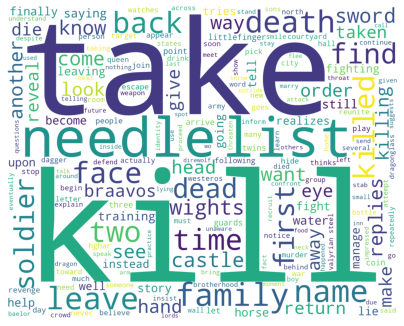

In [57]:
# Generate wordcloud
wordcloud_draw(arya, 'white')

#### What can we learn about Daenerys Targaryen? 

From the collocations we see that the words who frequently occurs together is that of:
> 1. Slits Throat:
>> * killing
> 2. Manyfaced Gods:
>> * is a deity worshiped by the mysterious cult of assassins known as the Faceless Men
> 3. Runs Away
> 4. Valyrian Steel 
>> * is a form of metal, the steel can hold an especially keen edge, remaining sharp forever without the need for honing

After Arya has to escapes from Winterfell, King's Landing, and more, she finds herself on a very strange journey. When in trouble, she receives help from a mysterious person and eventually becomes an apprentice for the Faceless Men. She also practises archery, swordmanship - where her famous sword "needle" made of valyrian steel is known. She ends up becoming a great warrior, slitting the throath of the Night King. 

From the worldcloud, some of the interesting words:
> * Kill
> * Needle
> * List
> * Take

After the escape from Winterfell and witnessing many deaths at a such young age, she often recite her "kill list". She is well known for her sword: needle.

We get a pretty good picture of Arya and her story. Not so much about what happens in the earliest days of the story, but how she grew and became as a consequence of those events.

### What can be learn from this individual character analysis?

Firstly, the wordclouds are pretty accurate about each character's storyline - but only if you are familiar with the series. Analysing and concluding anything is subjective from our perspective. 

What we can say, is that the individual analysis of words is not enough to understand a character's storyline or their actions, if someone is not familiar with the series, then it needs to be more contextualised. If we only consider what we can learn about these characters (if we pretend to not know the series), what we can learn are surface-level knowledge about them:
 * Cersei is a Queen
 * Daenerys has three dragons
 * Arya slits throats
 * Tyrion is from House Lannister
 * Jon has a connection with the Free Folk (Wildlings)
 
However, if one is familiar with the series, the wordclouds and collocations do to some extent depict the main events of the characters, but not a complete and chronological storyline. 

If we wanted instead to analyse what we can learn about Game of Thrones characters and their stories without knowing anything about them beforehand, we could intead of tokenising each word, we could do a sentenced based analysis of the text from the Fandom Wiki page. So in the future one could try to see if tokenising sentences would help, as well as looking at other aspects of the text than what we chose to do here. 

### Sentiment and Subjectivity Analysis (Comparative Analysis)

In this section we will purely be looking at the tokenzied words and then conclude subjectivity of a character's text and corresponding sentiment. The subjectivity of the language used for each character (and sentiment) will be conducted with the help from a subjectivity lexicon, which one can download from: [here](http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/) (or download the CSV file). From the lexicon, we are given these parameters:
 1. Type:
     * string: weaksubj or strongsubj (a word has either weak or strong subjectivity connotation)
 2. Length:
     * integer: length of word (typically one)
 3. Word1:
     * string: the word that has these attributes
 4. Pos1:
     * string: grammatical tagging (is the word a noun, verb, etc.)
 5. Stemmed1:
     * string: the suffix of the word
 6. Priorpolarity:
     * string: negative if the word is negatively charged and positive if positively charged

For this analysis, we only keep type, word, and priorpolarity; as these are the only one needed to check for subjectivity and sentiment.

In [40]:
text = [jon, cersei, tyrion, dae, arya]

In [41]:
data = pd.DataFrame(columns = characters)

In [42]:
import more_itertools as mit

# Daenerys has the longest document, thus we padd the rest of the characters documents with 
# None, so to have equal lengths
data['Jon Snow'] = list(mit.padded(jon, "", 17201))
data['Cersei Lannister'] = list(mit.padded(cersei, "", 17201))
data['Tyrion Lannister'] = list(mit.padded(tyrion, "", 17201))
data['Daenerys Targaryen'] = list(mit.padded(dae, "", 17201))
data['Arya Stark'] = list(mit.padded(arya, "", 17201))

In [44]:
# Creating dataframe from the subjectivity clues (type, word, and prior polarity is chosen and the rest is discarded)
sentiment_label = pd.read_csv('subjectivityclues.csv')

In [45]:
# Make polarity and type of subjectivity boolean, making the comparison to the character's documents easier
boolean_polarity = sentiment_label['Prior Polarity'].apply(lambda x: 1 if x == 'positive' else 0)
boolean_subjectivity = sentiment_label['Type'].apply(lambda x: 1 if x == 'strongsubj' else 0)

In [46]:
sentiment_label['Boolean Polarity']=boolean_polarity
sentiment_label['Boolean Type']=boolean_subjectivity

In [47]:
sentiment_label

,Type,Word,Prior Polarity,Boolean Polarity,Boolean Type
0,weaksubj,abandoned,negative,0,0
1,weaksubj,abandonment,negative,0,0
2,weaksubj,abandon,negative,0,0
3,strongsubj,abase,negative,0,1
4,strongsubj,abasement,negative,0,1
...,...,...,...,...,...
8217,strongsubj,zealot,negative,0,1
8218,strongsubj,zealous,negative,0,1
8219,strongsubj,zealously,negative,0,1
8220,strongsubj,zenith,positive,1,1


We have 8222 words in this lexicon

For the words that exists in the subjectivity lexicon, see which one exists in each of the character's documents; sentiment is determined by the percentage of negative/positive words and subjectivity the percentage of weak/strong words.

Here we define that **> 50%** is the threshold for leaning positive/negative and weak/strong. 

#### Sentiment and subjectivity for Jon Snow

In [48]:
set_jon = list(set(data['Jon Snow'].values).intersection(sentiment_label['Word']))
print(len(jon))
print(len(set_jon))

6965
683


There are 6965 words in total from the document, where 683 words from the subjectivity lexicon can be found in Jon Snow's document. 

In [49]:
words_in = len(set_jon)

In [50]:
P, T = 0, 0
for _,row in sentiment_label.iterrows():
    if row['Word'] in set_jon: 
        T += row['Boolean Type']
        P += row['Boolean Polarity']
print("The percentage of weak subjectivity:", (T/words_in)*100)
print("The percentage of words with strong subjectivity:", 100-((T/words_in)*100))
print("The percentage of words with positive charge:", (P/words_in)*100)
print("The percentage words with negative charge:", 100-((P/words_in)*100))
sent_jon = [(P/words_in)*100, (T/words_in)*100]

The percentage of weak subjectivity: 67.49633967789165
The percentage of words with strong subjectivity: 32.503660322108345
The percentage of words with positive charge: 46.99853587115666
The percentage words with negative charge: 53.00146412884334


#### Sentiment and subjectivity for Cersei Lannister

In [51]:
set_c = list(set(data['Cersei Lannister'].values).intersection(sentiment_label['Word']))
print(len(cersei))
print(len(set_c))

5841
753


The document has a total of 5841 words and there is a total of 753 words in subjectivity lexicon which appears in the document.

In [52]:
words_in = len(set_c)

In [53]:
P, T = 0, 0
for _,row in sentiment_label.iterrows():
    if row['Word'] in set_c: 
        T += row['Boolean Type']
        P += row['Boolean Polarity']
print("The percentage of weak subjectivity:", (T/words_in)*100)
print("The percentage of words with strong subjectivity:", 100-((T/words_in)*100))
print("The percentage of words with positive charge:", (P/words_in)*100)
print("The percentage words with negative charge:", 100-((P/words_in)*100))
sent_cer = [(P/words_in)*100, (T/words_in)*100]

The percentage of weak subjectivity: 73.30677290836654
The percentage of words with strong subjectivity: 26.69322709163346
The percentage of words with positive charge: 42.62948207171315
The percentage words with negative charge: 57.37051792828685


#### Sentiment and subjectivity for Tyrion Lannister

In [54]:
set_t = list(set(data['Tyrion Lannister'].values).intersection(sentiment_label['Word']))
print(len(tyrion))
print(len(set_t))

7091
756


Tyrion's document contain 7091 words, where 756 of the total words is also in the subjectivity lexicon .

In [55]:
words_in = len(set_t)

In [56]:
P, T = 0, 0
for _,row in sentiment_label.iterrows():
    if row['Word'] in set_t: 
        T += row['Boolean Type']
        P += row['Boolean Polarity']
print("The percentage of weak subjectivity:", (T/words_in)*100)
print("The percentage of words with strong subjectivity:", 100-((T/words_in)*100))
print("The percentage of words with positive charge:", (P/words_in)*100)
print("The percentage words with negative charge:", 100-((P/words_in)*100))
sent_tyr = [(P/words_in)*100, (T/words_in)*100]

The percentage of weak subjectivity: 74.73544973544973
The percentage of words with strong subjectivity: 25.264550264550266
The percentage of words with positive charge: 52.24867724867725
The percentage words with negative charge: 47.75132275132275


#### Sentiment and subjectivity for Daenerys Targaryen 

In [57]:
set_d = list(set(data['Daenerys Targaryen'].values).intersection(sentiment_label['Word']))
print(len(dae))
print(len(set_d))

17141
815


There are 17141 words in total, whereas 815 of the words appears in the subjectivity lexicon.

In [58]:
words_in = len(set_d)

In [59]:
P, T = 0, 0
for _,row in sentiment_label.iterrows():
    if row['Word'] in set_t: 
        T += row['Boolean Type']
        P += row['Boolean Polarity']
print("The percentage of weak subjectivity:", (T/words_in)*100)
print("The percentage of words with strong subjectivity:", 100-((T/words_in)*100))
print("The percentage of words with positive charge:", (P/words_in)*100)
print("The percentage words with negative charge:", 100-((P/words_in)*100))
sent_dae = [(P/words_in)*100, (T/words_in)*100]

The percentage of weak subjectivity: 69.32515337423312
The percentage of words with strong subjectivity: 30.674846625766875
The percentage of words with positive charge: 48.466257668711656
The percentage words with negative charge: 51.533742331288344


#### Sentiment and subjectivity for Arya Stark

In [60]:
set_a = list(set(data['Arya Stark'].values).intersection(sentiment_label['Word']))
print(len(arya))
print(len(set_a))

5381
550


5381 words in the document where 550 of those words are in the subjectivity lexicon.

In [61]:
words_in = len(set_a)

In [62]:
P, T = 0, 0
for _,row in sentiment_label.iterrows():
    if row['Word'] in set_a: 
        T += row['Boolean Type']
        P += row['Boolean Polarity']
print("The percentage of weak subjectivity:", (T/words_in)*100)
print("The percentage of words with strong subjectivity:", 100-((T/words_in)*100))
print("The percentage of words with positive charge:", (P/words_in)*100)
sent_ar = [(P/words_in)*100, (T/words_in)*100]

The percentage of weak subjectivity: 69.27272727272728
The percentage of words with strong subjectivity: 30.72727272727272
The percentage of words with positive charge: 45.09090909090909


#### Comparison between characters

In [86]:
sent = pd.DataFrame(columns = ['Character','Positive Polarity (%)', 'Negative Polarity (%)', 'Strong Subjectivity (%)', 'Weak Subjectivity (%)'])
sent['Character']=characters

In [88]:
sent['Positive Polarity (%)'] = [sent_jon[0], sent_cer[0], sent_tyr[0], sent_dae[0], sent_ar[0]]
sent['Negative Polarity (%)'] = [100-sent_jon[0], 100-sent_cer[0], 100-sent_tyr[0], 100-sent_dae[0], 100-sent_ar[0]]
sent['Weak Subjectivity (%)'] = [sent_jon[1], sent_cer[1], sent_tyr[1], sent_dae[1], sent_ar[1]]
sent['Strong Subjectivity (%)'] = [100-sent_jon[1], 100-sent_cer[1], 100-sent_tyr[1], 100-sent_dae[1], 100-sent_ar[1]]

In [89]:
sent

,Character,Positive Polarity (%),Negative Polarity (%),Strong Subjectivity (%),Weak Subjectivity (%)
0,Jon Snow,46.998536,53.001464,32.503660,67.496340
1,Cersei Lannister,42.629482,57.370518,26.693227,73.306773
2,Tyrion Lannister,52.248677,47.751323,25.264550,74.735450
3,Daenerys Targaryen,48.466258,51.533742,30.674847,69.325153
4,Arya Stark,45.090909,54.909091,30.727273,69.272727




Comparing charatcer's percentage of **Polarity/Sentiment**:

From the table we can see that **Tyrion** has the highest positive polarity at 52.2%. With the defined threshold at **>50%**, Tyrion's overall sentiment is positive. The rest of the characters only have positive polarity around +40%. Therefore, everyone apart from Tyrion, are overall negative in sentiment. **Cersei** is the character with the highest negative sentiment percentage, 57.4%. 

What does this mean? Tyrion's character description (biography and personality) on the fandom page is more positive in nature compared to other characters, where Cersei then is negative in nature. Is this due to the authors? Or is it accurate depiction from the TV-Series/books? We will conduct subjectivity analysis next, and we have decided that if a character's percentage is found to be 'subjective', it is the author's from the fanpage who are biased, otherwise we say it is an accurate depiction of that character. 
<br>
Comparing charatcer's percentage of **Subjectivity**:

From the table above we can see that all of the characters are weak in subjectivity, where **Tyrion** has the highest weak subjectivity percentage at 74.7%. Conclusively we say that all of the characters are weak in subjectivity, thus it must mean that the characters are described accurately on the fandom page from the TV-series (or books).

If the user knows about Game of Thrones, **Tyrion** is certainly an overall well-liked character; he is funny, intelligent, and brave. It is interseting that **Jon** and **Arya** especially had a negative sentiment, as these are generally liked characters, whilst **Cersei** is an overall disliked character. However, one must acknowledge that their storyline often involve a lot of violence and this definitely has an influence on the overall sentiment. 

## Discussion

#### What went well? 

From a data perspective we were able to obtain the necessary data by web scraping. The tools used for the individual character analysis were effective, such as the collocations and the wordclouds - as they did reprsent certain aspects of each character. For our comparative sentiment analysis we used a subjectivity lexicon and utilised it appropriately. 

Overall we were able to achieve our motivation: use the Fandom page to see what we can learn about certain characters and their storyline, as well as compare characters by their sentiment. 

#### What is still missing? What could be improved? 

Reseraching and analyse the dataset more thoroughly before doing the analysis, so we know what we are working with. 

As mentioned in the textanalysis part, we were unable to get a clear description of each character's storyline, especially if a user was unfamiliar with the series. For the future we could try to tokenise the sentences and contexualise the documents. That being said, it is another universe so it would be difficult to understand everything from a textanalysis, as certain terms "white walkers", "wildlings", etc., would not provide any insights without any definitions. 

For the sentiment analysis we could have defined a threshold that included neutral in sentiment, because there was no character that ultimately had a strong preference for positive sentiment, only small preference towards positive (and negative). We did not include neutral, as we wanted a more simple definition to see if there were differences. In subjectivity we found that all of the characters were weak in subjectivity and thus, these fandom description are accurate in nature. By our definition "weak" means accurate and "strong" means biased - we could have compared the subjectivity with other fanpages or the book to conclude more accurate statements.  